# Coding Example: Data Scraping of the TVMVDB Online Database

**Introduction:** This is an excerpt from the code I wrote for an ongoing project to collect data from the TVMVDB Online Database (a comprehensive source of TV news clips in China, covering nearly 200 channels and over 1 million news clips)

Script by Xiaoyang Zhang

09/2022

In [1]:
import requests
import re
import pprint
import time
from bs4 import BeautifulSoup
from lxml import etree
from urllib import parse
import numpy as np
import pandas as pd
import math
from tqdm import tqdm
import datetime
from fake_useragent import UserAgent

%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [16]:
### Random User-Agent generator

headers = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36"}

def random_all_headers(uuid='', keyword=''):
    
    if uuid == '':
        referer = 'http://bjdx.tvmvdb.com/home/search/index.html?languageType=1&keyword=' + keyword
    else:
        referer = 'http://bjdx.tvmvdb.com/home/play/index.html?languageType=1&ids=' + uuid
    
    return {
        'Accept': 'application/json, text/javascript, */*; q=0.01', 
        'Accept-Encoding': 'gzip, deflate', 
        'Accept-Language': 'zh-CN,zh;q=0.9', 
        'Connection': 'keep-alive', 
        #'Content-Length': '48', 
        'Content-Type': 'application/x-www-form-urlencoded; charset=UTF-8', 
        'Host': 'bjdx.tvmvdb.com', 
        'Origin': 'http://bjdx.tvmvdb.com', 
        'Referer': referer, 
        #'User-Agent': UserAgent(use_cache_server=False).random, 
        'User-Agent': UserAgent().random, 
        'X-Requested-With': 'XMLHttpRequest'
    }

In [3]:
for i in range(10):
    print(random_all_headers()['User-Agent'])

Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:22.0) Gecko/20130328 Firefox/22.0
Mozilla/5.0 (Windows NT 6.1; WOW64; rv:29.0) Gecko/20120101 Firefox/29.0
Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/31.0.1650.16 Safari/537.36
Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2224.3 Safari/537.36
Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2226.0 Safari/537.36
Mozilla/4.0 (compatible; MSIE 8.0; Windows NT 6.1; WOW64; Trident/4.0; SLCC2; .NET CLR 2.0.50727; Media Center PC 6.0; .NET CLR 3.5.30729; .NET CLR 3.0.30729; .NET4.0C)
Mozilla/5.0 (Windows NT 6.4; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2225.0 Safari/537.36
Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/34.0.1866.237 Safari/537.36
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1944.0 Safari/537.36
Mozilla/5.0 (compatible; MSIE 10.6; Win

## Extract transcribed text of videos

In [3]:
### Extract text from video with already transcribed text

def get_vtext_text(uuid):
    voice_url = 'http://bjdx.tvmvdb.com/home/play/getvideovoice.html'

    data = {
        'token': '', 
        'uuid': uuid
    }

    voice_json = requests.post(url=voice_url, data=data, headers=random_all_headers(uuid=uuid)).json()
    lines = voice_json[1]
    vtext_text = ''
    for line in lines:
        vtext_text += line['text'] + ' '
    
    return vtext_text


In [4]:
### Get url of video files

def video_URL(uuid):
    vpage_url = 'http://bjdx.tvmvdb.com/home/play/index.html?languageType=1&ids=' + uuid
    random_ua = {'User-Agent': UserAgent().random}
    vpage_text = requests.get(url=vpage_url, headers=random_ua).text
    # print(vpage_text)
    vURL = re.findall('(?<=videoUrl = ").*(?=";)', vpage_text)[0]
    return vURL


In [5]:
### Extract text from untranscribed text: transcribe, then extract text

def get_vtext_audio(uuid):
    text_url = 'http://bjdx.tvmvdb.com/home/formatdata/getvideotext.html'

    data = {
        'video_url': video_URL(uuid), 
        'uuid': uuid
    }

    text_json = requests.post(url=text_url, data=data, headers=random_all_headers(uuid=uuid)).json()
    lines = text_json[1]
    vtext_audio = ''
    for line in lines:
        vtext_audio += line['text'].replace('\n', '') + ' '
    
    return vtext_audio


In [6]:
### Combine two text extraction methods above

def get_vtext(uuid):
    if get_vtext_text(uuid) != '':
        return get_vtext_text(uuid)
    else:
        return get_vtext_audio(uuid)

## Collect video information

In [23]:
### Get info of 12 videos on each page

def video_info_onepage(keyword_zh, date, channelid, pageid, in_page=12, lite=False):
    all_info_list = []
    
    keyword = parse.quote(keyword_zh)
    
    url = 'http://bjdx.tvmvdb.com/home/search/getdata.html'
    data = {
        'keyword': keyword, 
        'page': str(pageid), 
        'mode': '3', 
        'date_limit_type': '0', 
        'date_sort': '0', 
        'date_time': date + ',' + date,
        'search_way': '0', 
        'uid': '0', 
        'channels': str(channelid)
    }
    
    print(requests.post(url=url, data=data, headers=random_all_headers(keyword=keyword)).json())
    json_1 = requests.post(url=url, data=data, headers=random_all_headers(keyword=keyword)).json()[1]
    
    total_num = int(
        json_1['status']['total']
    )
    
    if total_num != 0: # At least one search result on given day
        page_data = json_1['data']
    
        for video in page_data[:max(in_page, total_num % 12)]:            
            pid = video['pid']
            programme = video['pname']
            date = list(map(lambda x: int(x), video['published'].split('-')))
            tags = video['tags']
#             if tags != '':
#                 tags = tags.split(',')
            title = video['title']
            uid = video['uid']
            channel = video['uname']
            uuid = video['uuid'] #
            #vURL = video_URL(uuid)
            if lite == False:
                vtext = get_vtext(uuid) # Order: get uuid, get url, get text
            else:
                vtext = ""

            info_list = [channel, programme, date[0], date[1], date[2], title, tags, vtext, uuid, uid, pid]

            all_info_list.append(info_list)
    
    return [total_num, all_info_list]
    

In [9]:
### Total number of given channel and date

def tn_onechannel(keyword_zh, date, channelid, pageid, in_page=12):
    
    keyword = parse.quote(keyword_zh)
    
    url = 'http://bjdx.tvmvdb.com/home/search/getdata.html'
    data = {
        'keyword': keyword, 
        'page': str(pageid), 
        'mode': '3', 
        'date_limit_type': '0', 
        'date_sort': '0', 
        'date_time': date + ',' + date,
        'search_way': '0', 
        'uid': '0', 
        'channels': str(channelid)
    }
    
    total_num = int(
        requests.post(url=url, data=data, headers=random_all_headers(keyword=keyword)).json()[1]['status']['total']
    )
    
    return total_num


In [22]:
### Test on searching for COVID-related news
print(video_info_onepage('疫', 1, in_page=1))

[['央视新闻', '24小时', 2022, 1, 11, '日本新冠肺炎疫情 应对奥密克戎 日本延长入境限制至2月底', ['为日本可以赢得一些应对疫情的时间'], '再来关注日本 日本首相安天文学翁在11号宣布 日本对大多数外国公民关闭边境的防御措施会延长到二月底 辞职就是为了遏制相关病毒 奥米克戎毒株的蔓延案件 维修说严格的入境限制措施实际上是有助于减缓奥秘克隆赌注的蔓延速度的速度的 为日本可以赢得一些应对疫情的时间 去年的11月30号 日本发现了第一例的奥秘 克斯顿猪感染病例 从那个时候开始的日本就决定了原则上停止外国人入境 但是日本公民及其配偶和有居留日本资格的外国人除外规定的期限当时暂定为一个月 但是去年的12月18号 岸田文雄表示了会把这个限制措施至少延长到今年年初 但是没有给 除截止的日期 现在的表示说有再次的延长 ', '365898b7-2fc1-4cb7-6db7-17930c4919b9', '1965', '117']]


In [8]:
### Get all search results givin channel and date

def video_info_allpage(keyword_zh, date, channelid, in_page=12, lite=False):
    allpage_list = []
    total_num = video_info_onepage(keyword_zh, date, channelid, 1, in_page, lite)[0]
    page_num = int(math.ceil(total_num / 12))
    
    for pageid in range(1, page_num+1):
        allpage_list += video_info_onepage(keyword_zh, date, channelid, pageid, in_page, lite)[1]
    
    return allpage_list
    

## Build dataframe given info_list

In [20]:
### A function that directly collect information and store it into dataframe
### Uses vinfo_list from make_list() as input

def make_results(vinfo_list):
    
    video_df = pd.DataFrame(
        columns=['channel', 'programme', 'year', 'month', 'day', 'title', 'tags', 'vtext', 'uuid', 'uid', 'pid']
    )
    
    print("*** Making Dataframe ***")
    for video in tqdm(vinfo_list, desc="Making dataframe"):
    # for video in vinfo_list:
        video_df.loc[len(video_df.index)] = video
    
    return video_df


## Dates on outer loop, channels on inner loop

In [10]:
### Get list of all channels

channel_dict = {}

for i in range(1, 4):
    channel_url = "http://nav.tvmvdb.com/External/getChannelList?page=1&pageNum=999&channelType=" + str(i)
    channels = requests.get(url=channel_url, headers=headers).json()
    
    for ch in channels:
        ch_dict = {
            'name': ch['name'], 
            'uid': ch['uid'], 
            'type': ch['type'], 
            'total_num': ch['total_num']
        }
        channel_dict[ch['name']] = ch_dict

print(len(channel_dict))

276


In [11]:
### Channels with at least one video

cnt = 0

uid_list = []
name_list = []
type_list = []
num_list = []

for chkey in channel_dict:
    ch = channel_dict[chkey]
    if ch['total_num'] > 0:
        cnt += 1
        uid_list.append(ch['uid'])
        name_list.append(ch['name'])
        type_list.append(ch['type'])
        num_list.append(ch['total_num'])
        
# print(cnt)
data = {'uid': uid_list, 'name': name_list, 'type': type_list, 'total_num': num_list}
channel_df = pd.DataFrame.from_dict(data)
channel_df


,uid,name,type,total_num
0,117,央视新闻,1,1437501
1,32,央视综合,1,131725
2,44,央视国际,1,514085
3,225,CGTN,1,43225
4,24,央视财经,1,487857
...,...,...,...,...
192,277,武汉少儿,3,142
193,278,武汉电视剧,3,772
194,280,武汉科技生活,3,2000
195,279,武汉经济,3,6


In [12]:
channel_df.sort_values(by='total_num', ascending=False)[:50]

,uid,name,type,total_num
0,117,央视新闻,1,1437501
2,44,央视国际,1,514085
4,24,央视财经,1,487857
62,68,BTV新闻,2,384926
32,70,上海东方卫视,2,383345
39,35,上海新闻综合,2,368306
133,95,凤凰资讯,2,310930
106,30,江苏公共频道,2,288961
93,118,上海第一财经,2,216658
153,47,东南卫视,2,191410


array([[<AxesSubplot:title={'center':'total_num'}>]], dtype=object)

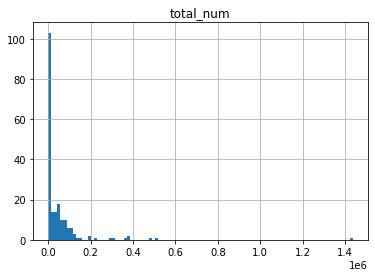

In [24]:
channel_df.hist(bins=100)

In [27]:
channel_df.describe()

,total_num
count,1.970000e+02
mean,5.104196e+04
std,1.269606e+05
min,1.000000e+00
25%,1.161000e+03
50%,1.222700e+04
75%,5.623600e+04
max,1.435976e+06


In [13]:
### A function that prints all dates between given start and end dates, in 'yyyy-mm-dd' format
### Reference: 健忘主义，"https://blog.csdn.net/qq_35515661/article/details/89638054"

def days_between(begin_date, end_date):
    date_list = []
    begin_date = datetime.datetime.strptime(begin_date, "%Y-%m-%d")
    end_date = datetime.datetime.strptime(end_date,"%Y-%m-%d")
    
    while begin_date <= end_date:
        date_str = begin_date.strftime("%Y-%m-%d")
        date_list.append(date_str)
        begin_date += datetime.timedelta(days=1)
    
    return date_list


In [14]:
### ## Dates on outer loop, channels on inner loop

def make_list(keyword, begin_date, end_date, cname_list, lite=False):
    list_made = []
    
    for day in days_between(begin_date, end_date):
        print('****** ' + day + ' ******')
        for i in tqdm(range(len(cname_list))):
            cname = cname_list[i]
            cid = channel_dict[cname]['uid']
            # print(str(i+1) + ". " + cname)

            list_made += video_info_allpage(keyword, day, cid, lite=lite)
    
    return list_made


In [16]:
### Test run

cname_list = list(filter(lambda x: 40000 <= channel_dict[x]['total_num'] <= 50000, channel_dict))
print(cname_list)
print("*"*10)

test_out = make_results(make_list('疫', '2022-01-17', '2022-01-19', cname_list))
test_out

['CGTN', '央视国防军事', '山东卫视', '云南卫视', '广东卫视', '浙江卫视', '海南卫视', 'BTV体育', '上海国际频道', '江苏城市频道', '上海都市频道', '广州台', '广西新闻', '三沙卫视', '无锡都市资讯频道']
**********
****** 2022-01-17 ******
1. CGTN


Page progress: 0it [00:00, ?it/s]


2. 央视国防军事


Page progress: 100%|██████████| 1/1 [00:06<00:00,  6.96s/it]


3. 山东卫视


Page progress: 100%|██████████| 1/1 [00:10<00:00, 10.01s/it]


4. 云南卫视


Page progress: 100%|██████████| 1/1 [00:04<00:00,  4.81s/it]


5. 广东卫视


Page progress: 100%|██████████| 2/2 [00:37<00:00, 18.72s/it]


6. 浙江卫视


Page progress: 100%|██████████| 1/1 [00:10<00:00, 10.34s/it]


7. 海南卫视


Page progress: 100%|██████████| 1/1 [00:03<00:00,  3.35s/it]


8. BTV体育


Page progress: 0it [00:00, ?it/s]


9. 上海国际频道


Page progress: 0it [00:00, ?it/s]


10. 江苏城市频道


Page progress: 0it [00:00, ?it/s]


11. 上海都市频道


Page progress: 0it [00:00, ?it/s]


12. 广州台


Page progress: 0it [00:00, ?it/s]


13. 广西新闻


Page progress: 0it [00:00, ?it/s]


14. 三沙卫视


Page progress: 100%|██████████| 1/1 [00:08<00:00,  8.55s/it]


15. 无锡都市资讯频道


Page progress: 0it [00:00, ?it/s]


****** 2022-01-18 ******
1. CGTN


Page progress: 0it [00:00, ?it/s]


2. 央视国防军事


Page progress: 100%|██████████| 1/1 [00:03<00:00,  3.41s/it]


3. 山东卫视


Page progress: 100%|██████████| 1/1 [00:11<00:00, 11.94s/it]


4. 云南卫视


Page progress: 100%|██████████| 1/1 [00:03<00:00,  3.63s/it]


5. 广东卫视


Page progress: 100%|██████████| 1/1 [00:30<00:00, 30.21s/it]


6. 浙江卫视


Page progress: 100%|██████████| 1/1 [00:07<00:00,  7.88s/it]


7. 海南卫视


Page progress: 100%|██████████| 1/1 [00:04<00:00,  4.50s/it]


8. BTV体育


Page progress: 0it [00:00, ?it/s]


9. 上海国际频道


Page progress: 0it [00:00, ?it/s]


10. 江苏城市频道


Page progress: 0it [00:00, ?it/s]


11. 上海都市频道


Page progress: 0it [00:00, ?it/s]


12. 广州台


Page progress: 0it [00:00, ?it/s]


13. 广西新闻


Page progress: 0it [00:00, ?it/s]


14. 三沙卫视


Page progress: 0it [00:00, ?it/s]


15. 无锡都市资讯频道


Page progress: 0it [00:00, ?it/s]


****** 2022-01-19 ******
1. CGTN


Page progress: 0it [00:00, ?it/s]


2. 央视国防军事


Page progress: 0it [00:00, ?it/s]


3. 山东卫视


Page progress: 100%|██████████| 1/1 [00:05<00:00,  5.00s/it]


4. 云南卫视


Page progress: 0it [00:00, ?it/s]


5. 广东卫视


Page progress: 100%|██████████| 1/1 [00:06<00:00,  6.15s/it]


6. 浙江卫视


Page progress: 100%|██████████| 1/1 [00:03<00:00,  3.48s/it]


7. 海南卫视


Page progress: 0it [00:00, ?it/s]


8. BTV体育


Page progress: 0it [00:00, ?it/s]


9. 上海国际频道


Page progress: 0it [00:00, ?it/s]


10. 江苏城市频道


Page progress: 0it [00:00, ?it/s]


11. 上海都市频道


Page progress: 0it [00:00, ?it/s]


12. 广州台


Page progress: 0it [00:00, ?it/s]


13. 广西新闻


Page progress: 0it [00:00, ?it/s]


14. 三沙卫视


Page progress: 100%|██████████| 1/1 [00:10<00:00, 10.69s/it]


15. 无锡都市资讯频道


Page progress: 0it [00:00, ?it/s]


*** Making Dataframe ***


Making dataframe: 100%|██████████| 90/90 [00:00<00:00, 169.91it/s]


,channel,programme,year,month,day,title,tags,vtext,uuid,uid,pid
0,央视国防军事,军事报道,2022,1,17,天津警备区紧急筹措物资支援抗疫一线,天津市疫情防控形势严峻,连日来 天津市疫情防控形势严峻 天津警备区紧急筹措防寒医疗生活等防疫物资十元疫情防控一线 累...,3e2d69ee-f70b-8cdc-9cf7-3eb2be88b6e7,268,18551
1,央视国防军事,军事报道,2022,1,17,春运首日 武警官兵守护旅客回家路,加之疫情精准防控的要求,2012年春运 今天起正式拉开大幕 据与交通部门预计 今年的春运从今天起至2月25号结束 共...,85ef047a-9f70-af33-b3a4-f960f768d2ac,268,18551
2,央视国防军事,国防军事早报,2022,1,17,天津 2000余名民兵投入疫情防控,投入疫情防控中心在协助展开核酸检测,近日 天津市多个区域发现新官肺炎确诊病例 天津警备区出动2000名民兵 投入疫情防控中心在协...,e2c15d80-3343-2c68-acb8-c8039e7878c3,268,19111
3,央视国防军事,国防军事早报,2022,1,17,中国援柬军医专家组获柬埔寨“和平骑士勋章”,第16批专家组抵减后多次深入基层和疫情,1月14号柬埔寨副首相兼国防大臣迪班为中国人民解放军第16批援柬医疗专家组授勋表彰专家组在协...,8bfa0dba-bc90-2f5e-fdbe-1da07e56d731,268,19111
4,山东卫视,早安山东,2022,1,17,山东预计发送旅客2850万人次,游戏做好春运疫情防控和服务保障工作,今年春运 山东预计发送旅客2850万人次 春运期间 全省道路运输将投放省市际线路班车车970...,ddc4549c-b149-aa06-5e86-bea4a89c9f27,50,1744
...,...,...,...,...,...,...,...,...,...,...,...
85,浙江卫视,正午播报,2022,1,19,正午关注 疫情防控 省内多地开展周期性巡检 严把疫情防控关口,舟山定海执法人员发现某水果店未能出示有效入境货物检验检疫证明,近日 我省多地监管部门对沿街商铺销售单位进行周期巡检 舟山定海执法人员发现某水果店未能出示有...,a4e93fd1-ef7c-7f8e-2b6c-a54a59ca7613,51,702
86,浙江卫视,正午播报,2022,1,19,正午关注 新型冠状病毒肺炎疫情最新情况,,1月18日0到24时 浙江新增无症状感染者九例 均为境外输入排查密切接触者均已实施集中隔离 ...,38ad3720-3703-4e3a-2671-ca0c15165d06,51,702
87,三沙卫视,三沙新闻,2022,1,19,袁光平调研安全生产和疫情防控工作,,昨天，三沙市委书记袁光平赴文昌清澜港三沙交通补给码头调研安全生产和疫情防控等工作，强调要深入...,9ae73b06-f460-1249-ef0f-148a2dae7744,204,1920
88,三沙卫视,南海直播室,2022,1,19,国务院联防联控机制医疗救治组印发《新冠病毒核酸20合1混采检测技术规范》,对疫情防控,据国家卫健委发布消息 为进一步做好相关病毒核酸检测 对疫情防控 争取宝贵时间 在目前五盒10...,196e8b20-6f06-bb80-01d3-a30b17bf4aa9,204,1963


In [51]:
test_out.to_csv("test_out.csv")

In [28]:
### Tests: days with low and high COVID cases

low_day = make_results(make_list('疫', '2021-08-01', '2021-08-01', ['央视新闻'], lite=True))
low_day

****** 2021-08-01 ******
1. 央视新闻


Page progress: 100%|██████████| 8/8 [01:23<00:00, 10.39s/it]


*** Making Dataframe ***


Making dataframe: 100%|██████████| 95/95 [00:00<00:00, 164.88it/s]


,channel,programme,year,month,day,title,tags,vtext,uuid,uid,pid
0,央视新闻,24小时,2021,8,1,疫情传播链仍在延长 各地紧急加强防控·北京 北京昌平第二轮核酸排查 结果均为阴性,为及时控制疫情赢得了时间,,d7034f5c-4b9c-d426-4b9d-1f3db36f4cbf,117,1965
1,央视新闻,24小时,2021,8,1,疫情传播链仍在延长 各地紧急加强防控·江苏 南京三轮全员核酸检测 累计报告204例,南京在疫情防控发布会上介绍去20号至今的南京全市全是已经进行的三轮核酸检测,,151e60dc-02eb-d757-3bf6-7eca57f0a021,117,1965
2,央视新闻,24小时,2021,8,1,疫情传播链仍在延长 各地紧急加强防控·江苏南京 今起开始补检 移动核酸检测车开进小区,根据当前疫情发展的情况,,6962e80f-7023-8750-a10a-f52eae3e77e1,117,1965
3,央视新闻,24小时,2021,8,1,聚焦奥运 东京奥运会第9个比赛日·男子100米决赛 苏炳添：超越自我 全力奔跑,此后相关疫情突然暴发,,1dfdd89e-e0b6-ff0e-294a-8332d8b2c83b,117,1965
4,央视新闻,东方时空,2021,8,1,疫情传播链仍在延长 各地紧急加强防控·福建厦门 厦门召开第三场疫情防控新闻发布会,那记者从厦门市第三场疫情防控发布会上了解到,,d17e1e48-3f3d-3e64-c025-c6bd713ad1f4,117,1932
...,...,...,...,...,...,...,...,...,...,...,...
90,央视新闻,新闻直播间,2021,8,1,河南郑州 确诊11名新冠肺炎患者 16名无症状感染者,郑州市召开新关税肺炎疫情防控新闻发布会,,9730c086-0dd7-8d29-6a23-10dfb3deba36,117,2348
91,央视新闻,新闻直播间,2021,8,1,江苏扬州 瘦西湖 大明寺等景区暂停开放,根据疫情发展形势,,f487489b-18c7-0ecd-bd95-9ae8d5f3da9a,117,2348
92,央视新闻,午夜新闻,2021,8,1,国务院联防联控机制发布会 本轮疫情仍有扩散风险,再来关注常态化疫情防控,,328415f0-8abf-5c3f-ef54-591e455567b4,117,1969
93,央视新闻,24小时,2021,8,1,新冠肺炎疫情·美国 日均新增超6.6万例 疫情反弹引担忧,疫情的发展形式让人担忧,,b0166866-c92d-2121-60d2-bb4eac416a63,117,1965


In [27]:
high_day = make_results(make_list('疫', '2021-12-20', '2021-12-20', ['央视新闻'], lite=True))
high_day

****** 2021-12-20 ******
1. 央视新闻


Page progress: 100%|██████████| 12/12 [02:00<00:00, 10.03s/it]


*** Making Dataframe ***


Making dataframe: 100%|██████████| 139/139 [00:00<00:00, 172.64it/s]


,channel,programme,year,month,day,title,tags,vtext,uuid,uid,pid
0,央视新闻,24小时,2021,12,20,“汉语盘点2021”揭晓年度字词 “治” “建党百年” “疫” “元宇宙” 当选,,,ca2878cb-b95a-c812-9971-7e1c8c03b417,117,1965
1,央视新闻,24小时,2021,12,20,新冠肺炎疫情防控·国务院联防联控机制新闻发布会 全力防范疫情经海上输入,全力防范疫情经海上输入,,1cff1bbf-e90a-04cd-9521-85f6ee466308,117,1965
2,央视新闻,24小时,2021,12,20,新冠肺炎疫情防控·国务院联防联控机制新闻发布会 全力做好重点时段疫情防控和运输服务保障,在疫情防控方面,,5036ce70-f65c-3dc5-20f9-a1be2562e009,117,1965
3,央视新闻,24小时,2021,12,20,新冠肺炎疫情防控·国务院联防联控机制新闻发布会 基于全球疫情形势倡导非必要非紧急不出境,还是要密切的关注境外疫情信息和前往国的入境管制的要求,,78f5bff1-7e83-86b1-7bf1-82beec9a4a39,117,1965
4,央视新闻,24小时,2021,12,20,新冠肺炎疫情防控·国务院联防联控机制新闻发布会 加强口岸管理 对人员流动严格管控,各地疫情精准防控,,0fbe6997-bee5-ca58-9d2f-ceff6329d3bd,117,1965
...,...,...,...,...,...,...,...,...,...,...,...
134,央视新闻,午夜新闻,2021,12,20,德国 新冠肺炎疫情 从英国入境德国旅客必须强制隔离两周,无论是否已接种相关疫苗或者感染后已康复,,8817a032-0068-79ed-2bb5-7a19329b7ae5,117,1969
135,央视新闻,午夜新闻,2021,12,20,伊朗 新冠肺炎疫情 伊朗首次报告奥密克戎毒株感染病例,全球疫情方面,,84184a92-fbb2-81c1-7417-a0f3f2b7c421,117,1969
136,央视新闻,午夜新闻,2021,12,20,浙江 新冠肺炎疫情防控 采取积极措施 加强疫情防控,浙江省也积极采取多种措施加强疫情防控,,d5363e8b-9b71-1f07-dacf-66317ea46af0,117,1969
137,央视新闻,午夜新闻,2021,12,20,内蒙古 新冠肺炎疫情防控 满洲里首批集中隔离人员解除隔离,继续来关注疫情防控,,1621ca08-3ded-26c8-7a14-ffd803dc13af,117,1969
